# Conjugate Gradient Descent

In [22]:
%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import autograd.numpy as np
from autograd import grad, jacobian, hessian

import plot as p
import cg
import matplotlib.pyplot as plt

from rosenbrock import rosenbrock

assert "autograd" in np.__file__ # Need to make sure that we get the correct numpy - my config/other imports might import the default one.

# Linear CG

## 2d Example

Remember that CG is used to solve a linear function,

$$
Ax = b
$$

by instead minimizing,

$$
f(x) = \frac{1}{2} x^T A x - b^T x
$$

In [3]:
A = np.array([
    [1, 0],
    [0, 3],
])
b = np.array([
    [0],
    [0],
])

def _reshape_grid(x):
    return x.T[:,:,np.newaxis]
    
# x needs to be a list of column vectors
def f(x):
    if len(x.shape) == 2 and x.shape[0] == 2:
        x = _reshape_grid(x)
    
    assert len(x.shape) == 3
    dims = A.shape[0]
    assert x.shape[1:] == (dims, 1)
    xr = x
    xl = x.transpose((0, 2, 1))
    return (0.5 * np.matmul(xl, np.matmul(A, xr)) - np.matmul(b.T, xr)).flatten()

In [4]:
x0 = np.array([1, 0.3])
positions = cg.conjugate_gradient(A, b.flatten(), x0)

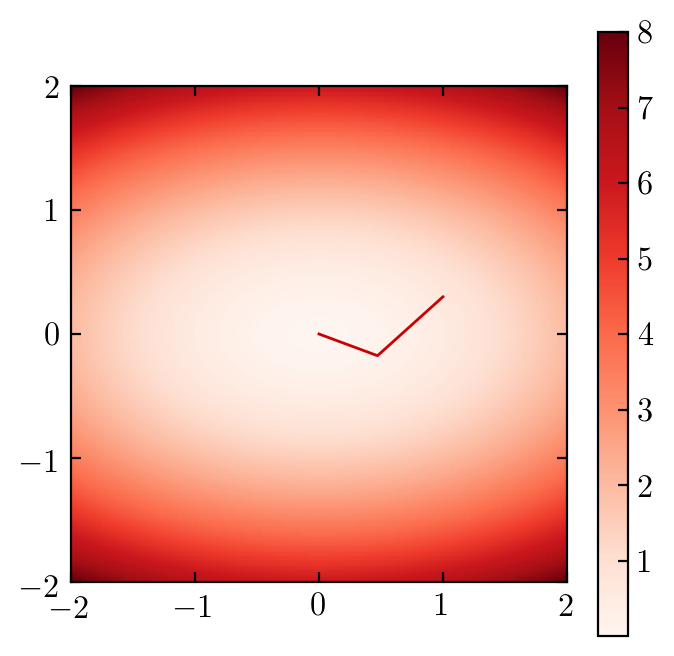

In [5]:
ax = p.plot_func(f, typ="image")
ax.plot(positions[:,0], positions[:,1])

## Large Example

Above we showed visually how CG works in a simple 2d problem. Now lets see how it performs in a large problem.

The first problem is to construct a large PSD $A$ matrix.

In [42]:
def construct_Ab_inputs(dims, eigenvalues):
    
    r = np.random.random((dims, dims))
    q, _ = np.linalg.qr(r)
    
    assert np.isclose(np.dot(q[:,0], q[:,1]), 0) # columns are orthogonal

    A = np.matmul(q.T, np.matmul(np.diag(eigenvalues), q))
    b = np.random.uniform(1, 10, size=dims)    
    return A, b

1001
250


[None]

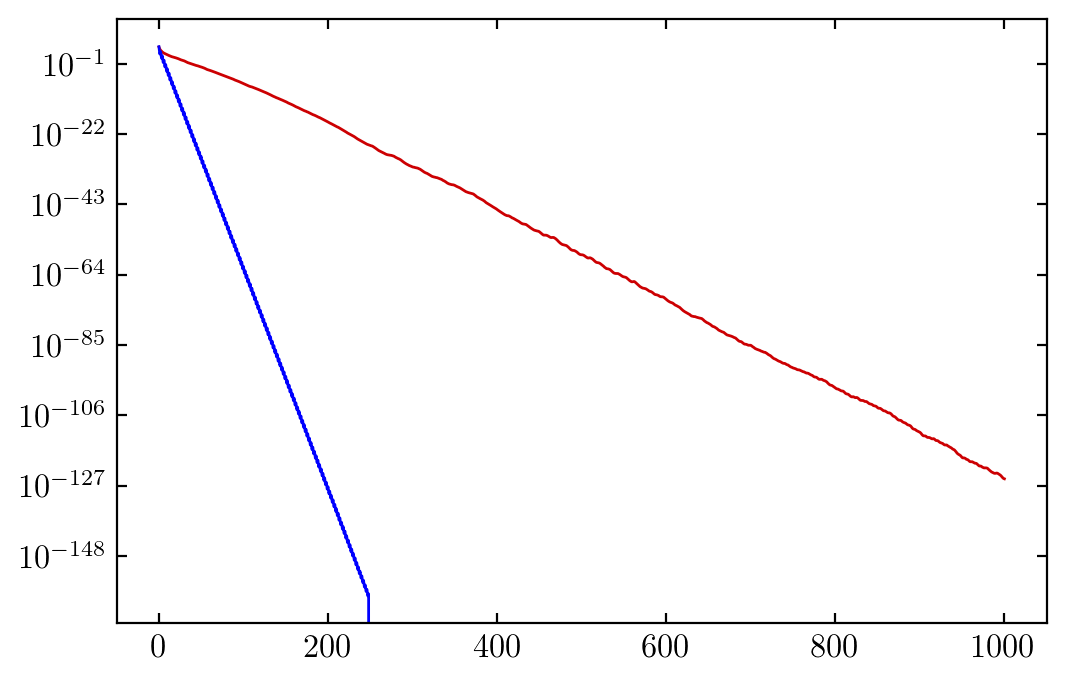

In [52]:
dims = int(1e3)
_, ax = plt.subplots()

for ev in [
    np.random.uniform(10, 1000, size=dims),
    np.concatenate((np.random.uniform(9, 11, size=dims//2), np.random.uniform(999, 1001, size=dims//2))),
]:
    A, b = construct_Ab_inputs(dims, ev)
    x0 = np.random.random(dims)

    positions, residual_norm = cg.conjugate_gradient(A, b, x0)
    print(len(positions))

    assert np.allclose(np.matmul(A, positions[-1]), b)
    ax.plot(residual_norm)
ax.set(yscale="log")

# Nonlinear CG

## 2d Rosenbrock

[[ 1.          1.        ]
 [ 1.3125      1.        ]
 [ 1.74215718  1.45389394]
 [-2.48144987  4.67628431]
 [-2.34468012  4.75183627]
 [-2.46676883  4.84934734]
 [-2.40742309  4.90015677]
 [-3.3131234   8.5391411 ]
 [-3.01414119  8.63005805]
 [-3.09120849  8.64287006]
 [-3.05668026  9.26691557]]


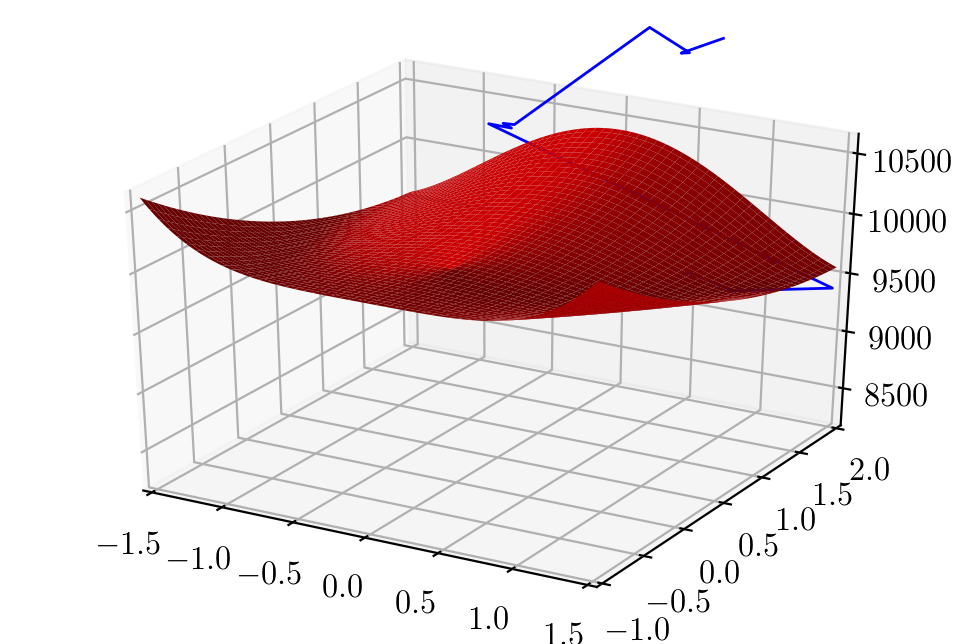

In [43]:
ax = p.plot_func(rosenbrock, typ="surface", lim=[-1.5, 1.5, -1, 2])

x0 = np.array([1., 1.])
pos = cg.fletcher_reeves(rosenbrock, grad(rosenbrock), x0)
print(pos)

ax.plot(pos[:,0], pos[:,1], rosenbrock(pos.T))